# Topic modelling with Gensim : the LDA algorithm

LDA is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar.

### Revised (January 2022) to read all data from the database

### Installation instructions

*    This is a Google Colab notebook. You must have a Google account with a Google Drive to store/ load file grid.xlsx. This is not really needed in the algorithm and only serves to show some grid search iterations.

*    Download the notebook from its location in GitHub and allow the code to access your Google Drive

*   Launch the notebook and put your own credentials in the pyodbc.connect() call in the chunk with title "Connect to Virtuoso database"





In [1]:
## To load grid.xlsx

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pyodbc

In [3]:
!apt-get install virtuoso-opensource

Reading package lists... Done
Building dependency tree       
Reading state information... Done
virtuoso-opensource is already the newest version (6.1.6+repack-0ubuntu9).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [4]:
!pip install pyLDAvis

In [5]:
import gensim
import pandas as pd
import numpy as np

import re
import pprint

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from pprint import pprint

import pyodbc

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


###Connect to Virtuoso database

In [6]:
c = pyodbc.connect('DRIVER=/usr/lib/odbc/virtodbc.so;HOST=lod.csd.auth.gr:1111;UID=xxxxx;PWD=xxxxx;DATABASE=ESTAT')

In [7]:
#set encoding
c.setdecoding(pyodbc.SQL_CHAR, encoding='latin-1')
c.setencoding(encoding="latin-1")

In [8]:
cursor = c.cursor()

In [9]:
def load_table(cursor,query):
  cursor.execute(query)
  t1 = cursor.fetchall()
  df = pd.DataFrame.from_records(t1, columns=[x[0] for x in cursor.description])
  return df

### Step 2. Pre-processing
***
#### Load Glossary articles from the database 

* Definitions from dat_glossary.
* Titles from dat_link_info (with resource_information_id=1, i.e. Eurostat, see ESTAT.V1.mod_resource_information).
* Match above on id.


In [10]:
query      = """SELECT T1.id, T1.definition, T2.title 
                FROM ESTAT.V1.dat_glossary as T1 
                INNER JOIN ESTAT.V1.dat_link_info as T2  
                  ON T1.id=T2.id 
                WHERE T2.resource_information_id=1 """

Gloss_concepts = load_table(cursor,query)
Gloss_concepts = Gloss_concepts[['id', 'title', 'definition']]

Gloss_concepts


,id,title,definition
0,1,Accident at work,An accident at work in the framework ...
1,5,Fatal accident at work,A fatal accident at work refers to an...
2,6,Non-fatal accident at work,A non-fatal accident at work is...
3,8,Aggregate demand,Aggregate demand is the total amount of ...
4,9,Goods and services account,The goods and services account shows ...
...,...,...,...
1309,2319,Actual individual consumption (AIC),"Actual individual consumption , abbrevia..."
1310,2321,Activity rate,Activity rate is the percentage of a...
1311,2322,Activation policies,The activation policies are policies ...
1312,2324,Active enterprises - FRIBS,"<Brief user-oriented definition, one or a fe..."


#### Delete records with empty definitions and carry out data cleansing


In [11]:

Gloss_concepts = Gloss_concepts.dropna(axis=0,how='any')
print(Gloss_concepts.isnull().sum())
Gloss_concepts.reset_index(drop=True, inplace=True)

#import unicodedata as ud

def clean(x, quotes=True):
    if pd.isnull(x): return x  
    x = x.strip()
    
    ## make letter-question mark-letter -> letter-quote-space-letter !!! but NOT in the lists of URLs!!!
    if quotes:
        x = re.sub(r'([A-Za-z])\?([A-Za-z])','\\1\' \\2',x) 
    
    ## make letter-question mark-space lower case letter letter-quote-space letter
    x = re.sub(r'([A-Za-z])\? ([a-z])','\\1\' \\2',x) 

    ## delete ,000 commas in numbers    
    x = re.sub(r'\b(\d+),(\d+)\b','\\1\\2',x) ## CORRECTED
    
    ## delete  000 spaces in numbers
    x = re.sub(r'\b(\d+) (\d+)\b','\\1\\2',x) ## CORRECTED
    
    ## remove more than one spaces
    x = re.sub(r' +', ' ',x)
    
    ## remove start and end spaces
    x = re.sub(r'^ +| +$', '',x,flags=re.MULTILINE) 
    
    ## space-comma -> comma
    x = re.sub(r' \,',',',x)
    
    ## space-dot -> dot
    x = re.sub(r' \.','.',x)
    
    x = re.sub(r'â.{2}',"'",x) ### !!! NEW: single quotes are read as: âXX
    
    #x = x.encode('latin1').decode('utf-8') ## â\x80\x99
    #x = ud.normalize('NFKD',x).encode('ascii', 'ignore').decode()
    
    return x


Gloss_concepts['title'] = Gloss_concepts['title'].apply(clean)
Gloss_concepts['title'] = Gloss_concepts['title'].apply(lambda x: re.sub(r'\?','-',x)) ## also replace question marks by dashes
Gloss_concepts['definition'] = Gloss_concepts['definition'].apply(clean)

Gloss_concepts.head(5)

id            0
title         0
definition    0
dtype: int64


,id,title,definition
0,1,Accident at work,An accident at work in the framework of the ad...
1,5,Fatal accident at work,A fatal accident at work refers to an accident...
2,6,Non-fatal accident at work,A non-fatal accident at work is an accident wh...
3,8,Aggregate demand,Aggregate demand is the total amount of goods ...
4,9,Goods and services account,The goods and services account shows the balan...


#### Delete "special" records

* i.e. redirections.



In [12]:
## Drop The records with definitions "The revision ..." and "Redirect to ..." 

idx = Gloss_concepts[Gloss_concepts['definition'].str.startswith('The revision #')].index
print(idx)
Gloss_concepts.drop(idx , inplace=True)
idx = Gloss_concepts[Gloss_concepts['definition'].str.startswith('Redirect to')].index
print(idx)
Gloss_concepts.drop(idx , inplace=True)
Gloss_concepts.reset_index(drop=True, inplace=True)
Gloss_concepts

Int64Index([ 230,  292,  384,  386,  433,  436,  438,  439,  504,  519,  530,
             557,  588,  729,  742,  775,  826,  889,  891,  912,  960,  961,
             969, 1003, 1007, 1133, 1144, 1182, 1231],
           dtype='int64')
Int64Index([], dtype='int64')


,id,title,definition
0,1,Accident at work,An accident at work in the framework of the ad...
1,5,Fatal accident at work,A fatal accident at work refers to an accident...
2,6,Non-fatal accident at work,A non-fatal accident at work is an accident wh...
3,8,Aggregate demand,Aggregate demand is the total amount of goods ...
4,9,Goods and services account,The goods and services account shows the balan...
...,...,...,...
1280,2319,Actual individual consumption (AIC),"Actual individual consumption, abbreviated as ..."
1281,2321,Activity rate,Activity rate is the percentage of active pers...
1282,2322,Activation policies,The activation policies are policies designed ...
1283,2324,Active enterprises - FRIBS,"<Brief user-oriented definition, one or a few ..."


#### Add the title to the column "definition"

In [13]:
Gloss_concepts['definition'] = Gloss_concepts['title'] +'. '+Gloss_concepts['definition']
Gloss_concepts

,id,title,definition
0,1,Accident at work,Accident at work. An accident at work in the f...
1,5,Fatal accident at work,Fatal accident at work. A fatal accident at wo...
2,6,Non-fatal accident at work,Non-fatal accident at work. A non-fatal accide...
3,8,Aggregate demand,Aggregate demand. Aggregate demand is the tota...
4,9,Goods and services account,Goods and services account. The goods and serv...
...,...,...,...
1280,2319,Actual individual consumption (AIC),Actual individual consumption (AIC). Actual in...
1281,2321,Activity rate,Activity rate. Activity rate is the percentage...
1282,2322,Activation policies,Activation policies. The activation policies a...
1283,2324,Active enterprises - FRIBS,Active enterprises - FRIBS. <Brief user-orient...


### 3. Pre-processing input data (cont).
***

Next we define a function _sent_to_words_ which accepts a series of texts and:
* Converts everything to lowercase and drops accents, 
* Deletes stop words, 
* Tokenizes the texts, 
* Apply Porter's stemmer and keeps as final tokens the resulting terms with minimum length 5. 

We call this function with the articles definitions in column "definition" of dataframe _Gloss_concepts_.    
The result, _texts_ is a nested list with 1285 outer elements corresponding to the articles.   
The inner lists contain the tokens for each text.

In [14]:
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.porter import PorterStemmer
def sent_to_words(sentences):
    p = PorterStemmer()
    for sentence in sentences:
        sentence = str(gensim.utils.simple_preprocess(sentence, deacc=True))
        sentence = remove_stopwords(sentence) 
        tokens = gensim.utils.tokenize(sentence)
        sentence = [p.stem(token) for token in tokens if len(p.stem(token)) >= 5] ##minimum length = 5 
        yield(sentence)
                
texts = list(sent_to_words(Gloss_concepts['definition']))
#texts = list(sent_to_words(Gloss_concepts['definition']))
print('\nFirst 5 texts: \n',texts[:5])
print('\nTotal texts: ',len(texts),'\n')



First 5 texts: 
 [['accid', 'accid', 'framework', 'administr', 'collect', 'european', 'statist', 'accid', 'discret', 'occurr', 'cours', 'which', 'physic', 'mental', 'phrase', 'cours', 'whilst', 'engag', 'occup', 'activ', 'spent', 'includ', 'traffic', 'accid', 'cours', 'exclud', 'accid', 'journei', 'between', 'workplac', 'definit', 'accid', 'modul', 'accid', 'other', 'relat', 'health', 'problem', 'labour', 'survei', 'principl', 'except', 'accid', 'mental', 'exclud', 'becaus', 'difficult', 'distinguish', 'relev', 'relat', 'health', 'problem', 'follow', 'accid', 'cover', 'respect', 'definit', 'includ', 'poison', 'other', 'person', 'accid', 'occur', 'premis', 'employ', 'other', 'which', 'emploi', 'victim', 'might', 'includ', 'accid', 'attend', 'cours', 'provid', 'servic', 'premis', 'anoth', 'employ', 'visit', 'purpos', 'cours', 'victim', 'accid', 'occur', 'other', 'visit', 'locat', 'outsid', 'premis', 'employ', 'which', 'employe', 'normal', 'accid', 'regular', 'break', 'includ', 'lunch', 

### 4. Creation of corpus and terms frequencies.
***

The next steps are:
* Create a vocabulary from _texts_ with name _id2word_. This is a dictionary with keys the numeric ids of the terms and the terms themselves as values. The terms are initially sorted alphabetically.
* Filter-out words which appear in less than 1% of the texts or in more than 80% of the texts. The result is 731 unique tokens.
* Create a mapping with name _corpus_ of texts to terms in the bag-of-words (BOW) format. Each text is mapped into a list with 2-tuples: (word id, word count in each text). Note that the **ordering of the terms in the _id2word_ vocabulary changes** (into the order of appearance in the texts).


In [15]:

from gensim import corpora

#Create Dictionary
id2word = corpora.Dictionary(texts) #Gensim creates a unique id for each word in the document. 
id2word.filter_extremes(no_below=0.01*len(texts), no_above=0.8)

print(id2word,'\n')

corpus = [id2word.doc2bow(text) for text in texts] 

print('First 5 texts in BOW format:\n')
print(corpus[:5],'\n')
print('First 5 texts in BOW format together with terms:\n')
for i in range(5):
    print([(id2word[term_id],term_id,freq) for (term_id,freq) in corpus[i]])

print('\nTotal texts: ',len(corpus))

Dictionary(731 unique tokens: ['activ', 'administr', 'although', 'anoth', 'arriv']...) 

First 5 texts in BOW format:

[[(0, 13), (1, 2), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 4), (8, 2), (9, 3), (10, 1), (11, 2), (12, 1), (13, 1), (14, 5), (15, 2), (16, 1), (17, 12), (18, 2), (19, 2), (20, 2), (21, 1), (22, 1), (23, 2), (24, 1), (25, 8), (26, 4), (27, 1), (28, 1), (29, 1), (30, 1), (31, 3), (32, 1), (33, 5), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 9), (45, 1), (46, 1), (47, 2), (48, 1), (49, 1), (50, 2), (51, 1), (52, 3), (53, 2), (54, 1), (55, 2), (56, 1), (57, 4), (58, 5), (59, 6), (60, 2), (61, 2), (62, 10), (63, 1), (64, 1), (65, 2), (66, 1), (67, 5), (68, 1), (69, 1), (70, 3), (71, 2), (72, 1), (73, 8), (74, 1), (75, 1), (76, 2), (77, 7), (78, 1), (79, 2), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 3), (86, 2), (87, 1), (88, 1), (89, 1), (90, 3), (91, 2), (92, 3), (93, 1), (94, 8), (95, 2), (96, 1), (97, 2), (98,

### 5. Grid search for the selection of the best LDA model.
***
The parameters in the call of the function _ldamodel.LdaModel()_ and the number of topics were selected by trial and error and also through **grid search runs**. The following dataframe and plot show the results of one **indicative** such run with a **subset** of the hyper-parameters. We run several such runs with different combinations and values for the hyper-parameters. 

Note that some parameters in the search (not shown in this example) were not related to the call to _gensim.models.ldamodel.LdaModel() function._ Examples were the lower and upper bounds on the appearance of terms in the texts.

The quality measure for the selection of the best LDA model is the coherence score. This is based on the work in Röder, M., Both, A., & Hinneburg, A. (2015, February). Exploring the space of topic coherence measures. In *Proceedings of the eighth ACM international conference on Web search and data mining* (pp. 399-408), available [here](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf). 



In [16]:
grid = pd.read_excel('/content/drive/MyDrive/grid.xlsx',index_col=0)   
grid

,num_topics,passes,alpha,decay,iterations,Coherence
0,18,10,symmetric,0.50,250,0.403904
1,18,10,symmetric,0.50,500,0.405463
2,18,10,symmetric,0.75,250,0.382357
3,18,10,symmetric,0.75,500,0.388442
4,18,10,symmetric,1.00,250,0.361309
...,...,...,...,...,...,...
103,22,50,auto,0.50,500,0.421268
104,22,50,auto,0.75,250,0.417549
105,22,50,auto,0.75,500,0.417838
106,22,50,auto,1.00,250,0.401768


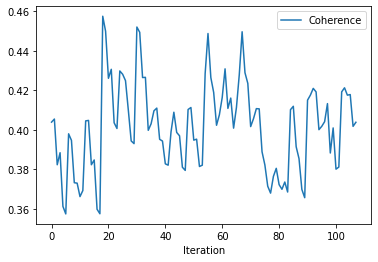

In [17]:
grid.plot.line(y='Coherence')
_ = plt.xlabel("Iteration")

The (disabled) code for this **indicative** grid search is shown below. Do **not** comment-out the first line. 

In [18]:
%%script false --no-raise-error ## DO NOT UN-COMMENT THIS! THIS CELL IS NOT SUPPOSED TO RUN

from gensim.models import CoherenceModel
from itertools import product

def expand_grid(dictionary):
    return pd.DataFrame([row for row in product(*dictionary.values())], 
                       columns=dictionary.keys())

dictionary = {'num_topics':[18,20,22], 'passes': [10,50], 'alpha': ['symmetric', 'asymmetric','auto'], 
              'decay': [0.5, 0.75, 1], 'iterations':[250,500]}

grid = expand_grid(dictionary)
print(grid)
best_coherence = 0
best_params = -1
for i in range(len(grid)):
    
    print('Testing with row ',i+1,' of ',len(grid),'\n')
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=grid.loc[i,'num_topics'],
                                           random_state=100,
                                           update_every=0,
                                           passes=grid.loc[i,'passes'],
                                           alpha=grid.loc[i,'alpha'],
                                           iterations=grid.loc[i,'iterations'],
                                           decay = grid.loc[i,'decay'],
                                           per_word_topics=True)
    
    print(grid.loc[i,:])
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda,'\n')
    grid.loc[i,'Coherence'] = coherence_lda
    
    if coherence_lda > best_coherence:
        best_coherence = coherence_lda
        best_params = i
        
    print('\nBest so far: ',best_coherence,' at row ',best_params,'\n')    

    grid.to_excel('grid.xlsx')

### 6. Fitting the selected LDA model
***

The next code shows the fitting of the LDA model with the selected parameters found (20 topics). These are not exactly the ones shown in the indicative grid search shown previously. For example, we found that we had to lower a little the _decay_ parameter. The coherence value of 0.42 is considered adequate. We store the fitted model in an object _lda_model_.

In [19]:
#Build LDA model

num_topics = 20
passes = 50
alpha='symmetric'
iterations = 500
decay = 0.40

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=0,
                                           passes=passes,
                                           alpha=alpha,
                                           iterations=iterations,
                                           decay = decay,
                                           per_word_topics=True)


from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.41994735158181695


### 7. Identification of the dominant topic per document.
***
In this section, we identify the dominant topic, its weight and its keywords, for each document. We define a dataframe _df_topic_sents_keywords_  in order to store these results. As it will be seen later, these are very useful as **complementary information to find and/or verify the interpretation of the topics**.

In function _format_topics_sentences()_ below, the list _ldamodel[corpus]_ has one nested list element per text. Each nested list contains tuples of the form (topic, contribution). We sort the firts element of each nested list by descending contribution to find the dominant topic and then, we retrieve for this topic, the list _wp_ of tuples (word, probability) for the most probable words, using the function _ldamodel.show_topic()_. We join these words into a list and put the result in column 'Topic_Keywords' of the dataframe.  


In [20]:
def format_topics_sentences(ldamodel=None, corpus=corpus):

    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]): 
        row = row_list[0]
        row = sorted(row, key=lambda x: (x[1]), reverse=True) ## sort the nested list by descending contribution
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        topic_num, prop_topic = row[0]
        wp = ldamodel.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original tokenized text and title to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df = pd.concat([sent_topics_df, Gloss_concepts['id'],Gloss_concepts['title']], axis=1)
    return(sent_topics_df)

In [21]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus)
df_topic_sents_keywords.rename(columns = {0:'Text tokenized definition'}, inplace = True)
df_topic_sents_keywords.rename(columns = {'id':'Text id','title':'Text title'}, inplace = True)
df_topic_sents_keywords = df_topic_sents_keywords[['Text id','Text title','Text tokenized definition','Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']]
df_topic_sents_keywords['Dominant_Topic'] = df_topic_sents_keywords['Dominant_Topic'].astype(int)
df_topic_sents_keywords


,Text id,Text title,Text tokenized definition,Dominant_Topic,Perc_Contribution,Topic_Keywords
0,1,Accident at work,"[accid, accid, framework, administr, collect, ...",19,0.3385,"enterpris, activ, legal, internet, which, publ..."
1,5,Fatal accident at work,"[fatal, accid, fatal, accid, refer, accid, whi...",18,0.8100,"death, statist, index, explain, eurostat, glos..."
2,6,Non-fatal accident at work,"[fatal, accid, fatal, accid, accid, which, vic...",16,0.4617,"build, tourism, permit, other, accommod, least..."
3,8,Aggregate demand,"[aggreg, demand, aggreg, demand, total, amount...",2,0.3477,"govern, local, statist, sourc, balanc, public,..."
4,9,Goods and services account,"[servic, account, servic, account, balanc, bet...",3,0.9159,"product, consumpt, gross, produc, output, mark..."
...,...,...,...,...,...,...
1280,2319,Actual individual consumption (AIC),"[actual, individu, consumpt, actual, individu,...",9,0.5152,"price, index, servic, transport, countri, indi..."
1281,2321,Activity rate,"[activ, activ, percentag, activ, person, relat...",5,0.8030,"labour, employ, person, emploi, employe, peopl..."
1282,2322,Activation policies,"[activ, polici, activ, polici, polici, design,...",5,0.6403,"labour, employ, person, emploi, employe, peopl..."
1283,2324,Active enterprises - FRIBS,"[activ, enterpris, brief, orient, definit, sen...",18,0.8135,"death, statist, index, explain, eurostat, glos..."


### 8. Most representative document for each topic.
***

Here, we are searching for the reverse, i.e. we want to find the document that best represents a given topic.We create the dataframe _sent_topics_sorteddf_mallet_ to store the results.

In [22]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords[['Text id','Text title','Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']].groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                             axis=0)

sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

sent_topics_sorteddf_mallet.columns = ['Text id','Text title','Topic_Num', 'Topic_Perc_Contrib', 'Topic Keywords' ]
sent_topics_sorteddf_mallet = sent_topics_sorteddf_mallet[['Topic_Num', 'Topic_Perc_Contrib', 'Topic Keywords','Text id','Text title']]

sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Topic Keywords,Text id,Text title
0,0,0.9887,"financi, social, incom, account, asset, transf...",1918,Financial instruments
1,1,0.9920,"manur, where, forecast, cover, water, liquid, ...",96,Cattle housing
2,2,0.9789,"govern, local, statist, sourc, balanc, public,...",382,Glossary:Government budget allocations for R&D...
3,3,0.9789,"product, consumpt, gross, produc, output, mark...",936,Production account
4,4,0.9894,"product, innov, process, account, environment,...",1291,Process innovation
5,5,0.9798,"labour, employ, person, emploi, employe, peopl...",859,Person available to work but not seeking
6,6,0.9806,"applic, protect, person, vehicl, decis, includ...",667,Temporary protection
7,7,0.9950,"materi, water, which, includ, organ, input, pr...",290,Material flow indicators
8,8,0.9905,"activ, servic, technolog, research, trade, sci...",938,Human resources in science and technology (HRST)
9,9,0.9814,"price, index, servic, transport, countri, indi...",504,Transport mode


### 9. The topics as a mix of keywords.
***

The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes with a certain weight to the topic.  This mix of keywords (limited to the top 10 keywords) is shown below, for each topic.


In [23]:
pprint(lda_model.print_topics())

## equivalently:
##for i in range(num_topics):
##    print([(id2word[term_id],prob) for (term_id,prob) in lda_model.get_topic_terms(i,topn=10)],'\n')

[(0,
  '0.056*"financi" + 0.054*"social" + 0.045*"incom" + 0.042*"account" + '
  '0.033*"asset" + 0.024*"transfer" + 0.023*"other" + 0.020*"household" + '
  '0.020*"contribut" + 0.018*"current"'),
 (1,
  '0.067*"manur" + 0.027*"where" + 0.025*"forecast" + 0.025*"cover" + '
  '0.024*"water" + 0.022*"liquid" + 0.022*"surfac" + 0.022*"emiss" + '
  '0.019*"slurri" + 0.019*"solid"'),
 (2,
  '0.088*"govern" + 0.033*"local" + 0.031*"statist" + 0.028*"sourc" + '
  '0.028*"balanc" + 0.027*"public" + 0.026*"posit" + 0.023*"deficit" + '
  '0.021*"differ" + 0.016*"extern"'),
 (3,
  '0.122*"product" + 0.048*"consumpt" + 0.046*"gross" + 0.043*"produc" + '
  '0.042*"output" + 0.029*"market" + 0.027*"sector" + 0.026*"institut" + '
  '0.026*"servic" + 0.022*"account"'),
 (4,
  '0.074*"product" + 0.063*"innov" + 0.051*"process" + 0.039*"account" + '
  '0.036*"environment" + 0.031*"servic" + 0.028*"activ" + 0.028*"improv" + '
  '0.026*"market" + 0.024*"manag"'),
 (5,
  '0.070*"labour" + 0.059*"employ" + 

### 10. Dominant topics.
***


To better understand the volume and distribution of topics, we construct the dataframe _df_dominant_topics_ with relevant information.


In [24]:
#Topic distribution across documents

# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,19,"enterpris, activ, legal, internet, which, publ...",83.0,0.0646
1,18,"death, statist, index, explain, eurostat, glos...",60.0,0.0467
2,16,"build, tourism, permit, other, accommod, least...",39.0,0.0304
3,2,"govern, local, statist, sourc, balanc, public,...",72.0,0.0560
4,3,"product, consumpt, gross, produc, output, mark...",53.0,0.0412
...,...,...,...,...
1280,9,"price, index, servic, transport, countri, indi...",NaN,NaN
1281,5,"labour, employ, person, emploi, employe, peopl...",NaN,NaN
1282,5,"labour, employ, person, emploi, employe, peopl...",NaN,NaN
1283,18,"death, statist, index, explain, eurostat, glos...",NaN,NaN


### 11. Visualization of the topics.
***

To visualize the fitted LDA model we use the _pyLDAvis_ package. This is the Python porting of the R package _LDAvis_, see [LDAvis vignette](https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf) for details and Chuang, Jason, Manning, Christopher D., and Heer, Jeffrey (2012). Termite: Visualization Techniques for Assessing Textual Topic Models, *Advanced Visual Interfaces* for the theory behind the visualization algorithm. The paper is available [here](https://dl.acm.org/doi/pdf/10.1145/2254556.2254572?casa_token=q2BavKP415QAAAAA:MhcYHzz4PJpC7dNkkm12GL-ohQRUXBgumPJ9l1t_5n3M4qVE1kdDqKGfPmtnR7qbale_ukS-2nJs). 

Note that the parameter _sort_topics=False_ in the call to function _pyLDAvis.gensim_models.prepare()_ is necessary, otherwise the numbering of the topics is different than the one in the rest of the analysis. Also, **the numbering of the topics start from zero**.

In [25]:
#Visualize the topics

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word,sort_topics=False)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.156384  0.067791       1        1   8.058178
1      0.047857  0.060599       2        1   3.699695
2     -0.035398  0.065435       3        1   3.079991
3     -0.278806  0.034773       4        1   5.676160
4     -0.215611 -0.172112       5        1   4.226892
5      0.079503  0.069608       6        1   4.926709
6      0.125782  0.097949       7        1   4.807886
7     -0.087129  0.100077       8        1   4.012226
8     -0.062962 -0.142397       9        1   4.709536
9      0.034991  0.025269      10        1   6.996806
10     0.140308 -0.012328      11        1   4.546716
11     0.109139 -0.157844      12        1   7.221229
12    -0.008784  0.081761      13        1   5.416886
13     0.117925  0.110972      14        1   5.797034
14     0.031848 -0.210580      15        1   4.199134
15    -0.167832  0.098969      16        1   2.368477
16     0.106449  0.114412      17        1   2.886115
17     0.098826 -0.129818      18        1  10.609968
18     0.131552 -0.048883      19        1   2.745560
19    -0.011274 -0.053651      20        1   4.014804, topic_info=           Term        Freq       Total Category  logprob  loglift
135     product  763.000000  763.000000  Default  30.0000  30.0000
29    enterpris  308.000000  308.000000  Default  29.0000  29.0000
307  agricultur  304.000000  304.000000  Default  28.0000  28.0000
0         activ  552.000000  552.000000  Default  27.0000  27.0000
30     european  584.000000  584.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
31       exampl   16.752763  159.598073  Topic20  -4.8520   0.9611
44       includ   19.810317  605.968250  Topic20  -4.6843  -0.2054
428      period   16.294960  253.058157  Topic20  -4.8797   0.4724
85       servic   16.630869  452.295675  Topic20  -4.8593  -0.0879
135     product   16.134937  763.593584  Topic20  -4.8895  -0.6419

[950 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
140       5  0.038989  abbrevi
140       6  0.024368  abbrevi
140       8  0.053610  abbrevi
140       9  0.053610  abbrevi
140      10  0.112094  abbrevi
...     ...       ...      ...
719       3  0.077897    yield
719       5  0.116846    yield
719      13  0.428436    yield
719      14  0.038949    yield
719      16  0.311590    yield

[3198 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

### 12. Interpretation of the topics and topic coherences.
***

For the interpretation of the topics, we inspect this visualization together:  
* with the information on the decomposition of topics into its main keywords (i.e. the same information as in 9. "The topics as a mix of keywords"). In each topic, the main keywords are here sorted by descending importance and plots are produced.
* with the information on the most representative article for each topic, see 8. "Most representative document for each topic".


Topic id:  1
('financi', 0.055696342)
('social', 0.053670067)
('incom', 0.045304086)
('account', 0.042185076)
('asset', 0.033335995)
('transfer', 0.024136484)
('other', 0.023211492)
('household', 0.020174565)
('contribut', 0.019702656)
('current', 0.01828855)


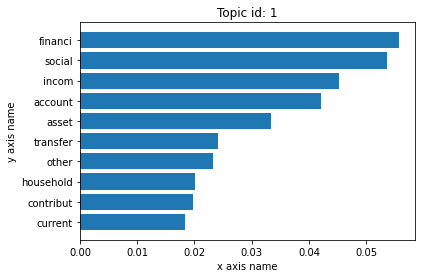


Topic id:  2
('manur', 0.06720413)
('where', 0.027432777)
('forecast', 0.025473962)
('cover', 0.025407314)
('water', 0.023858305)
('liquid', 0.022431156)
('surfac', 0.021925382)
('emiss', 0.021737572)
('slurri', 0.018986957)
('solid', 0.01883874)


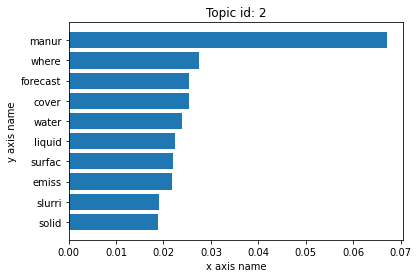


Topic id:  3
('govern', 0.08801002)
('local', 0.033005543)
('statist', 0.031143596)
('sourc', 0.027893977)
('balanc', 0.027695052)
('public', 0.02654167)
('posit', 0.026346272)
('deficit', 0.022922367)
('differ', 0.020682566)
('extern', 0.016403684)


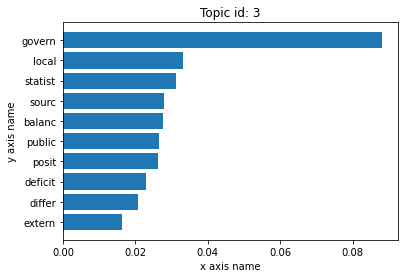


Topic id:  4
('product', 0.12226592)
('consumpt', 0.047726866)
('gross', 0.046400145)
('produc', 0.043285962)
('output', 0.041738205)
('market', 0.028690312)
('sector', 0.026900034)
('institut', 0.025616864)
('servic', 0.025548393)
('account', 0.022038028)


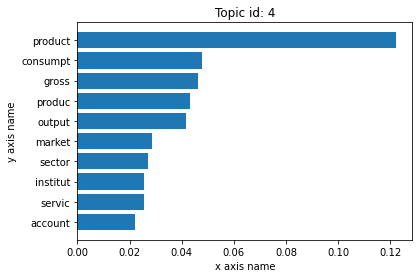


Topic id:  5
('product', 0.07416368)
('innov', 0.06263724)
('process', 0.050627306)
('account', 0.03875312)
('environment', 0.036366746)
('servic', 0.031238096)
('activ', 0.027738163)
('improv', 0.027585858)
('market', 0.026288755)
('manag', 0.024092965)


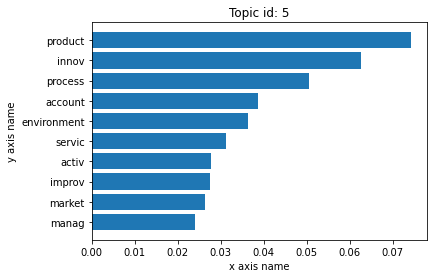


Topic id:  6
('labour', 0.07025115)
('employ', 0.05887681)
('person', 0.057192903)
('emploi', 0.037886243)
('employe', 0.027240826)
('peopl', 0.02632637)
('train', 0.02379307)
('number', 0.023102285)
('worker', 0.021780582)
('activ', 0.018371643)


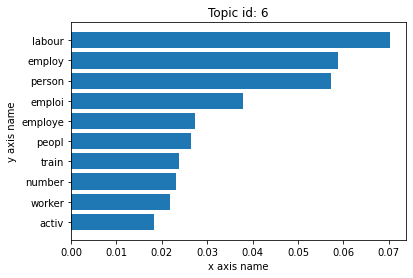


Topic id:  7
('applic', 0.04976231)
('protect', 0.043091096)
('person', 0.039499186)
('vehicl', 0.032155007)
('decis', 0.021524955)
('includ', 0.019625502)
('direct', 0.016783666)
('refer', 0.016321052)
('statu', 0.016248519)
('grant', 0.01623986)


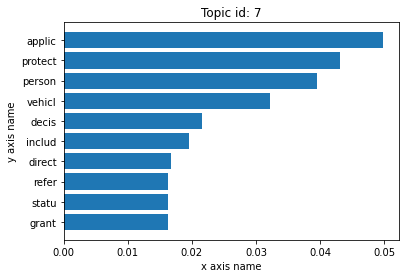


Topic id:  8
('materi', 0.060852148)
('water', 0.033568565)
('which', 0.031415615)
('includ', 0.03028)
('organ', 0.029121205)
('input', 0.028903484)
('product', 0.02739996)
('weight', 0.023420556)
('physic', 0.022136448)
('domest', 0.022003323)


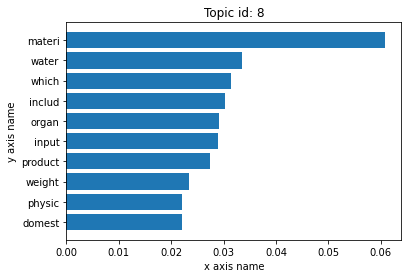


Topic id:  9
('activ', 0.089215316)
('servic', 0.041824665)
('technolog', 0.03334007)
('research', 0.019516714)
('trade', 0.018519808)
('scienc', 0.018417854)
('level', 0.018409831)
('knowledg', 0.018113377)
('section', 0.01758545)
('group', 0.01694009)


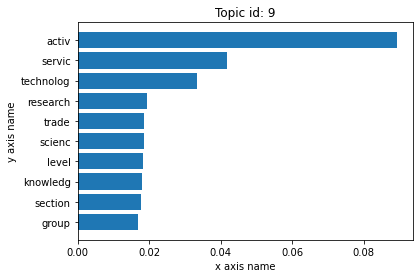


Topic id:  10
('price', 0.057297237)
('index', 0.0420792)
('servic', 0.037859824)
('transport', 0.034324694)
('countri', 0.024926051)
('indic', 0.022390539)
('purchas', 0.018447738)
('period', 0.016450504)
('other', 0.015147182)
('which', 0.015035748)


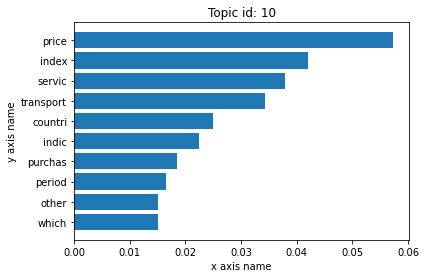


Topic id:  11
('region', 0.07260221)
('resid', 0.0521623)
('countri', 0.0366683)
('level', 0.026770294)
('popul', 0.02459521)
('territori', 0.023861486)
('urban', 0.022779636)
('border', 0.01983289)
('locat', 0.018340176)
('geograph', 0.017063875)


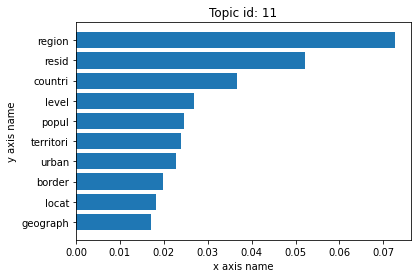


Topic id:  12
('statist', 0.06674537)
('survei', 0.036243778)
('classif', 0.030828929)
('collect', 0.02627463)
('inform', 0.0258154)
('european', 0.025516808)
('regul', 0.02310014)
('standard', 0.020454781)
('econom', 0.019806044)
('level', 0.019765591)


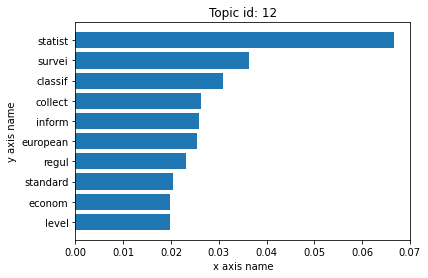


Topic id:  13
('agricultur', 0.09869292)
('product', 0.038445294)
('which', 0.030702481)
('other', 0.024757426)
('plant', 0.024362173)
('includ', 0.023575503)
('livestock', 0.022962557)
('harvest', 0.019832775)
('perman', 0.019019684)
('manag', 0.017051203)


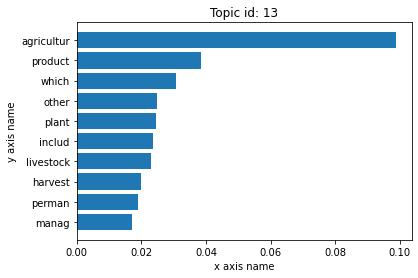


Topic id:  14
('popul', 0.052393306)
('number', 0.044521965)
('household', 0.042277876)
('incom', 0.040764082)
('period', 0.029822264)
('refer', 0.02315115)
('total', 0.022066824)
('calcul', 0.019515632)
('estim', 0.018296119)
('averag', 0.0153035205)


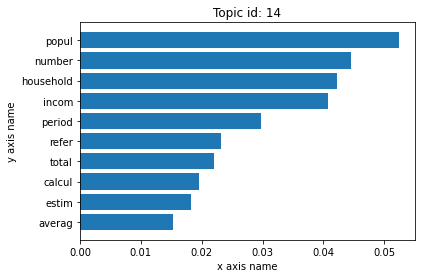


Topic id:  15
('indic', 0.06970274)
('health', 0.06480606)
('energi', 0.06160874)
('econom', 0.056217656)
('european', 0.026696753)
('develop', 0.025670305)
('polici', 0.024607228)
('condit', 0.02018133)
('electr', 0.018673943)
('gener', 0.018406617)


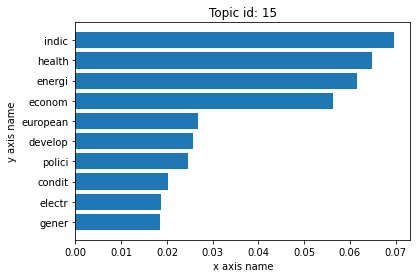


Topic id:  16
('expenditur', 0.07421835)
('invest', 0.06495864)
('equival', 0.0455759)
('includ', 0.04466404)
('direct', 0.02742857)
('capit', 0.02703815)
('privat', 0.025375366)
('gross', 0.024089817)
('exclud', 0.01692026)
('other', 0.016801333)


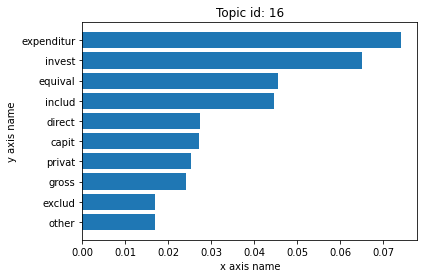


Topic id:  17
('build', 0.04144879)
('tourism', 0.03667103)
('permit', 0.034182895)
('other', 0.0296693)
('accommod', 0.028568516)
('least', 0.027191449)
('resid', 0.02495068)
('limit', 0.023872145)
('includ', 0.021903155)
('which', 0.020542532)


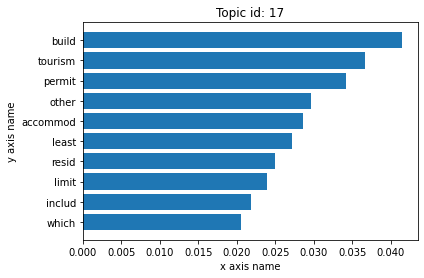


Topic id:  18
('european', 0.066953234)
('state', 0.0603596)
('member', 0.05314126)
('countri', 0.052093696)
('union', 0.036199726)
('nation', 0.020275269)
('trade', 0.016942285)
('which', 0.014517426)
('econom', 0.013972219)
('intern', 0.01309007)


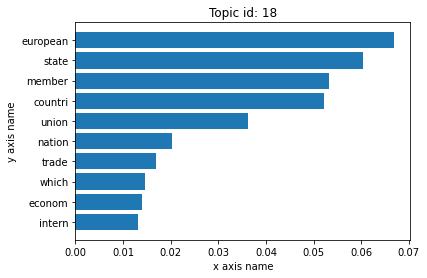


Topic id:  19
('death', 0.09839707)
('statist', 0.05775566)
('index', 0.041857526)
('explain', 0.0392412)
('eurostat', 0.037447263)
('glossari', 0.0371582)
('europa', 0.036583032)
('retriev', 0.03658301)
('oldid', 0.03392487)
('construct', 0.0324676)


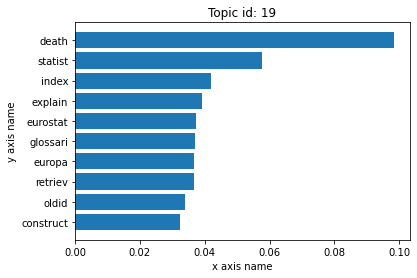


Topic id:  20
('enterpris', 0.1411941)
('activ', 0.038568623)
('legal', 0.024939291)
('internet', 0.021963961)
('which', 0.02153954)
('public', 0.02112378)
('calendar', 0.01878961)
('statist', 0.016252222)
('their', 0.015401964)
('refer', 0.014379232)


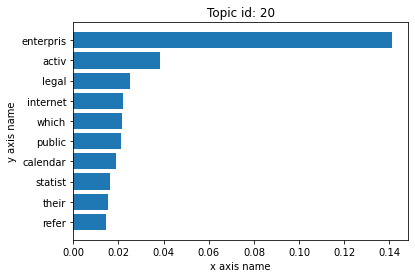

In [26]:

   
for topic_id in range(num_topics):
    print('\nTopic id: ',topic_id+1 )
    top_words = [(a,b) for (a,b) in sorted(lda_model.show_topic(topic_id,topn=10),key=lambda x: x[1], reverse=True)]
    for t in range(len(top_words)):
        print(top_words[t])
    y_axis = [t[0] for t in top_words]
    x_axis = [t[1] for t in top_words] 
    
    plt.barh(y_axis,x_axis)
    plt.gca().invert_yaxis()
    plt.title('title name')
    plt.ylabel('y axis name')
    plt.xlabel('x axis name')
    plt.title('Topic id: '+str(topic_id+1))
    plt.show()        



We end-up with the following interpretations of the 20 topics. Together with the topic names, we also give the coherence scores by topic. We can see that topic 1 "Social expenditure and households income" has the highest coherence while topic 3 "Government accounts and external debt" has the lowest.   


Topic  1. Coherence: 0.729425  Social expenditure and households income.  
Topic  2. Coherence: 0.517110  Farming, land and water resources.  
Topic  3. Coherence: 0.238667  Government accounts and external debt.  
Topic  4. Coherence: 0.573301  Production, consumption and gross accounts.  
Topic  5. Coherence: 0.451796  Product and process innovation.  
Topic  6. Coherence: 0.407004  Persons and employment.  
Topic  7. Coherence: 0.543049  Protection applications and asylum grants.  
Topic  8. Coherence: 0.354092  Material flows.  
Topic  9. Coherence: 0.467932  Science, research and technology.  
Topic 10. Coherence: 0.352649  Price indices.  
Topic 11. Coherence: 0.303228  Regions, demography and geography.  
Topic 12. Coherence: 0.445745  Statistical classifications.  
Topic 13. Coherence: 0.484077  Agriculture, farming and production.  
Topic 14. Coherence: 0.476922  Population, demography and income.  
Topic 15. Coherence: 0.339964  Health.  
Topic 16. Coherence: 0.276133  Invest

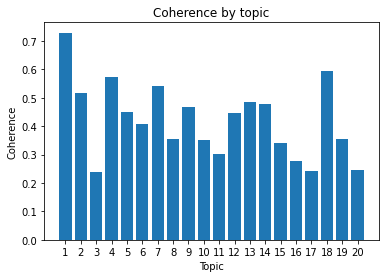

In [27]:
topic_names = [
'Social expenditure and households income',
'Farming, land and water resources',
'Government accounts and external debt',
'Production, consumption and gross accounts',
'Product and process innovation',
'Persons and employment',   
'Protection applications and asylum grants',   
'Material flows',
'Science, research and technology',
'Price indices',
'Regions, demography and geography', 
'Statistical classifications',
'Agriculture, farming and production', 
'Population, demography and income',
'Health',
'Investments and gross capital formation',
'Tourism accomodation',   
'Member States and trade', 
'Mortality',
'Enterprise statistics']

coh_topics = coherence_model_lda.get_coherence_per_topic(segmented_topics=None,with_std=False, with_support=False)

for (i,tn) in enumerate(topic_names):
    print('Topic {0:2d}. Coherence: {1:6f}  {2:s}.  '.format(i+1,coh_topics[i],tn))

fig, ax = plt.subplots()
x=np.arange(num_topics)+1
plt.bar(x=x,height=coh_topics)
plt.xlabel("Topic")
plt.ylabel("Coherence")
plt.title("Coherence by topic")
ax.set_xticks(x)
plt.show()
    

### 13. Outputs.
***

A first output in dataframe _topics_terms_df_ is for inspection only: a 20 x 732 matrix with the distribution of terms per topic. The row sums of this matrix are ones. 

In [28]:

topics_terms_mat = lda_model.get_topics()
print(topics_terms_mat.shape)
topics_terms_df = pd.DataFrame()
for topic_id in range(num_topics):
    topics_terms_df = topics_terms_df.append(pd.Series(topics_terms_mat[topic_id,:].transpose()), ignore_index=True)           
topics_terms_df.rename(columns=id2word, inplace=True)
topics_terms_df.insert(0,'Topic Name',topic_names)
print(topics_terms_df)
topics_terms_df.to_csv('topics_terms_df.write_csv',sep=';')

(20, 731)
                                    Topic Name     activ  ...    permit   sentenc
0     Social expenditure and households income  0.000189  ...  0.000011  0.000011
1            Farming, land and water resources  0.000025  ...  0.000566  0.000025
2        Government accounts and external debt  0.000030  ...  0.000030  0.000030
3   Production, consumption and gross accounts  0.006964  ...  0.000016  0.000016
4               Product and process innovation  0.027738  ...  0.000269  0.000022
5                       Persons and employment  0.018372  ...  0.000019  0.000019
6    Protection applications and asylum grants  0.000019  ...  0.002428  0.000019
7                               Material flows  0.003439  ...  0.000023  0.000023
8             Science, research and technology  0.089215  ...  0.000020  0.000020
9                                Price indices  0.000128  ...  0.000013  0.000013
10           Regions, demography and geography  0.001425  ...  0.000020  0.000020
11    

In [29]:
import numpy as np
np.sum(lda_model.get_topics(),axis=1)

array([0.99999994, 1.        , 0.99999994, 1.        , 0.99999994,
       0.99999994, 1.        , 0.99999994, 1.        , 1.        ,
       1.        , 1.        , 0.99999994, 1.0000001 , 0.99999994,
       1.        , 1.        , 1.        , 0.99999994, 0.99999994],
      dtype=float32)

The next output is for **insertion into the database**. It is the previous matrix in (row,column,value) format, in dataframe _tm_values_, exported to file **_tm_values.csv_** (delimiter=semicolon). All indices are zero-based.

In [30]:
pd.options.display.float_format = '{:.8f}'.format
tm_values = pd.DataFrame(columns=['Topic id','Term id','Probability'])
count = -1
for i in range(topics_terms_mat.shape[0]):
    for j in range(topics_terms_mat.shape[1]):
        count += 1
        tm_values.loc[count,'Topic id']=i
        tm_values.loc[count,'Term id']=j
        tm_values.loc[count,'Probability']=topics_terms_mat[i,j]

print(tm_values)
#pd.options.display.float_format = None
tm_values.to_csv('tm_values.csv',sep=';',index=False)

      Topic id Term id Probability
0            0       0  0.00018919
1            0       1  0.00001150
2            0       2  0.00001150
3            0       3  0.00001206
4            0       4  0.00001150
...        ...     ...         ...
14615       19     726  0.00002292
14616       19     727  0.00002292
14617       19     728  0.00002292
14618       19     729  0.00002292
14619       19     730  0.00002292

[14620 rows x 3 columns]


Dataframe _tm_topics_, exported into file **_tm_topics.csv_** (delimiter=semicolon) links the _tm_values_ with the topics information, with the zero-based _Topic id_ key. 

In [31]:
tm_topics = sent_topics_sorteddf_mallet.copy()
tm_topics.rename(columns={'Topic_Num':'Topic id'},inplace=True)
tm_topics.drop(columns=['Topic_Perc_Contrib','Text id','Text title'],inplace=True)
tm_topics = pd.concat([tm_topics, pd.Series(topic_names)],ignore_index=True,axis=1)
tm_topics.columns = ['Topic id', 'Topic keywords', 'Topic name']
print(tm_topics)
tm_topics.to_csv('tm_topics.csv',sep=';',index=False)

    Topic id  ...                                  Topic name
0          0  ...    Social expenditure and households income
1          1  ...           Farming, land and water resources
2          2  ...       Government accounts and external debt
3          3  ...  Production, consumption and gross accounts
4          4  ...              Product and process innovation
5          5  ...                      Persons and employment
6          6  ...   Protection applications and asylum grants
7          7  ...                              Material flows
8          8  ...            Science, research and technology
9          9  ...                               Price indices
10        10  ...           Regions, demography and geography
11        11  ...                 Statistical classifications
12        12  ...         Agriculture, farming and production
13        13  ...           Population, demography and income
14        14  ...                                      Health
15      

Similarly, dataframe _tm_terms_, exported into file **_tm_terms.csv_** (delimiter=semicolon) which links the _tm_values_ with the terms information, with the zero-based _Term id_ key. 

In [32]:
tm_terms = pd.DataFrame([id2word[t_id] for t_id in id2word],columns=['Term name'])
tm_terms.insert(0,value=range(len(id2word)),column='Term id') 
print(tm_terms)
tm_terms.to_csv('tm_terms.csv',sep=';',index=False)

     Term id      Term name
0          0          activ
1          1      administr
2          2       although
3          3          anoth
4          4          arriv
..       ...            ...
726      726        passeng
727      727        freight
728      728  significantli
729      729         permit
730      730        sentenc

[731 rows x 2 columns]
